# Practica 1 - Computer Vision

# Importación de librerías

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

import os
import gdown

# Importación de datos

In [2]:
# Crear el directorio de datos si no existe
data_dir = "data"
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

# URL de Google Drive en formato correcto para gdown
url = "https://drive.google.com/uc?id=1iGBv-VT5mm1RiouD-U2qWcU3BYqp2OwE"
zip_filename = "practica_1_dataset.zip"
zip_path = os.path.join(data_dir, zip_filename)

# Descargar el archivo
if not os.path.exists(zip_path):
    gdown.download(url, zip_path, quiet=False)
else:
    print("Data zipfile already exists")

Data zipfile already exists


In [3]:
import os
from zipfile import ZipFile
from concurrent.futures import ThreadPoolExecutor

data_dir = "data"
zip_filename = "practica_1_dataset.zip"
zip_path = os.path.join(data_dir, zip_filename)
subfolders = ["test", "train", "valid"]
full_paths = [os.path.join(data_dir, folder) for folder in subfolders]

if not all(os.path.isdir(path) for path in full_paths):
    with ZipFile(zip_path, 'r') as zf:
        with ThreadPoolExecutor() as exe:
            for file in zf.namelist():
                if not file.startswith("__MACOSX"):
                    exe.submit(zf.extract, file, path=data_dir)
else:
    print("test, train and valid folders already exist")

test, train and valid folders already exist


# EXPLORACION DE DATOS

## Exploración previa al etiquetado.

══════════════════════════════════════════════════
ESTADÍSTICAS BÁSICAS
══════════════════════════════════════════════════
Total de anotaciones: 4817
Número de imágenes únicas: 637
Clases disponibles: ['starfish' 'shark' 'fish' 'puffin' 'stingray' 'penguin' 'jellyfish']

══════════════════════════════════════════════════
DISTRIBUCIÓN DE CLASES
══════════════════════════════════════════════════


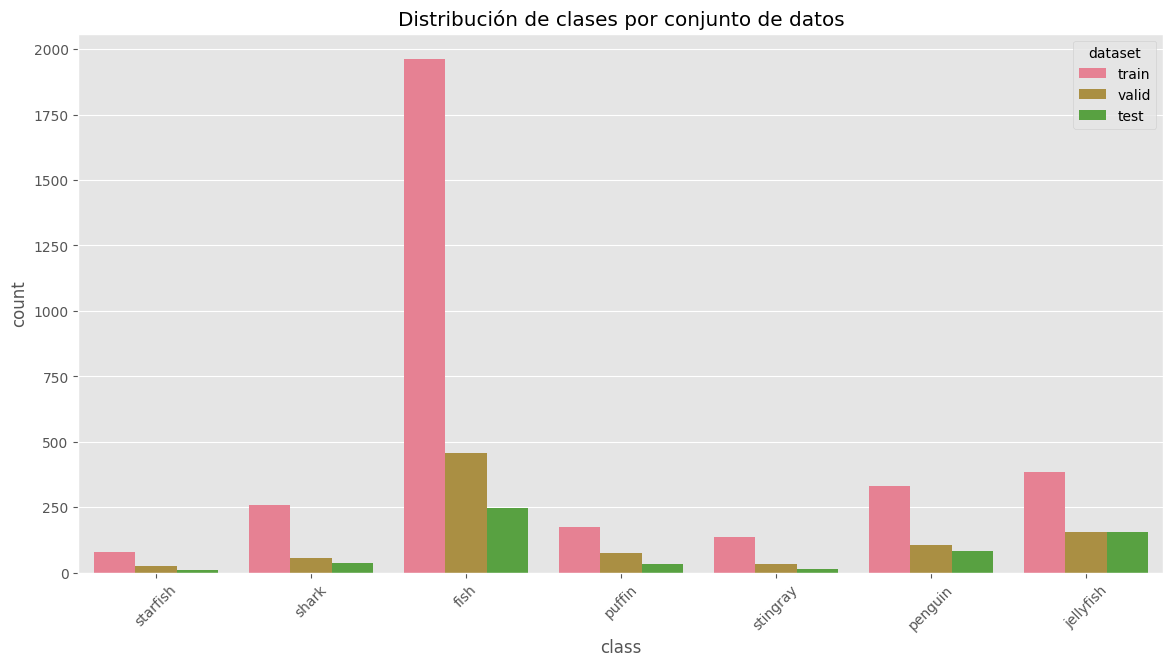


══════════════════════════════════════════════════
ANÁLISIS DE DIMENSIONES
══════════════════════════════════════════════════
Dimensiones más comunes:
   width  height  count
0    576    1024    519
1    768    1024   2963
2   1024     576    106
3   1024     768   1229

══════════════════════════════════════════════════
ANOTACIONES POR IMAGEN
══════════════════════════════════════════════════


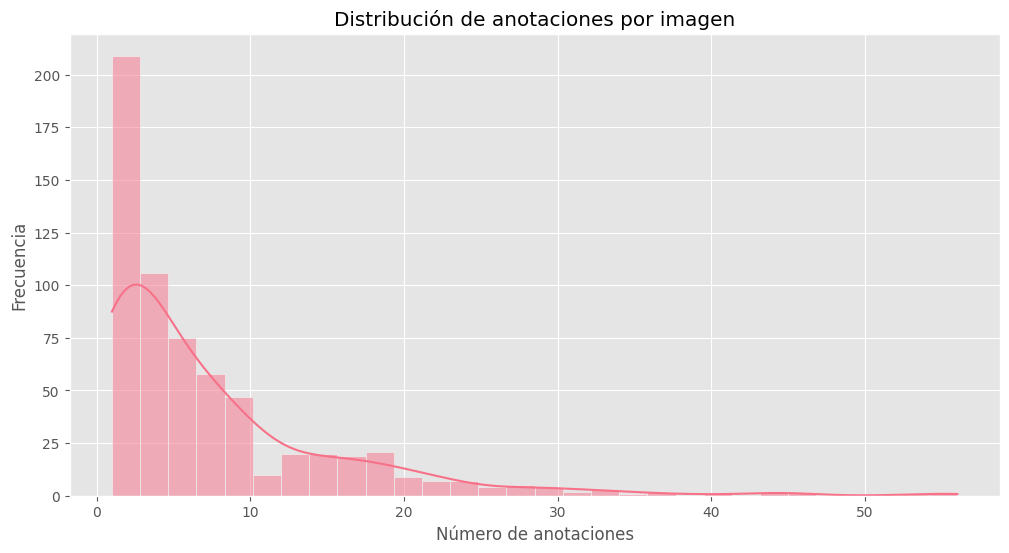


══════════════════════════════════════════════════
SUPERPOSICIÓN DE CLASES
══════════════════════════════════════════════════
Imágenes con múltiples clases: 198

Combinaciones:
('fish', 'shark'): 134 ocurrencias
('fish', 'stingray'): 80 ocurrencias
('shark', 'stingray'): 55 ocurrencias
('fish', 'starfish'): 14 ocurrencias
('shark', 'starfish'): 4 ocurrencias


In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Configuración de visualización
plt.style.use('ggplot')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)

# Cargar datos
def load_annotations(path):
    df = pd.read_csv(path)
    df['dataset'] = os.path.basename(os.path.dirname(path))
    return df

# Cargar todos los datasets
combined_df = pd.concat([
    load_annotations("data/train/annotations.csv"),
    load_annotations("data/valid/annotations.csv"),
    load_annotations("data/test/annotations.csv")
])

# Análisis básico
print("═"*50)
print("ESTADÍSTICAS BÁSICAS")
print("═"*50)
print(f"Total de anotaciones: {combined_df.shape[0]}")
print(f"Número de imágenes únicas: {combined_df['filename'].nunique()}")
print(f"Clases disponibles: {combined_df['class'].unique()}")

# Distribución de clases
print("\n" + "═"*50)
print("DISTRIBUCIÓN DE CLASES")
print("═"*50)
class_dist = combined_df.groupby(['dataset', 'class']).size().unstack(fill_value=0)

# Gráfico de distribución de clases
plt.figure(figsize=(14, 7))
sns.countplot(data=combined_df, x='class', hue='dataset')
plt.title('Distribución de clases por conjunto de datos')
plt.xticks(rotation=45)
plt.show()

# Análisis de dimensiones de imágenes
print("\n" + "═"*50)
print("ANÁLISIS DE DIMENSIONES")
print("═"*50)
dimension_counts = combined_df.groupby(['width', 'height']).size().reset_index(name='count')
print("Dimensiones más comunes:")
print(dimension_counts.head())


# Análisis de anotaciones por imagen
print("\n" + "═"*50)
print("ANOTACIONES POR IMAGEN")
print("═"*50)
annotations_per_image = combined_df.groupby('filename').size()

plt.figure(figsize=(12, 6))
sns.histplot(annotations_per_image, bins=30, kde=True)
plt.title('Distribución de anotaciones por imagen')
plt.xlabel('Número de anotaciones')
plt.ylabel('Frecuencia')
plt.show()

# Análisis de superposición de clases
print("\n" + "═"*50)
print("SUPERPOSICIÓN DE CLASES")
print("═"*50)
class_combinations = combined_df.groupby('filename')['class'].agg(lambda x: list(x.unique()))
print(f"Imágenes con múltiples clases: {sum(class_combinations.apply(len) > 1)}")

# Ejemplo de combinaciones comunes
from itertools import combinations
from collections import Counter

all_combinations = []
for classes in class_combinations:
    if len(classes) > 1:
        all_combinations.extend(combinations(sorted(classes), 2))

common_pairs = Counter(all_combinations).most_common(5)
print("\nCombinaciones:")
for pair, count in common_pairs:
    print(f"{pair}: {count} ocurrencias")


**Características del Dataset**

- El dataset contiene 637 imágenes únicas pero 4817 anotaciones totales, lo que indica una alta densidad de objetos por imagen. Esto habrá que tenerlo en cuenta a la hora de realizar las reetiquetar las imágenes

- Hay 7 clases marinas (starfish, shark, fish, puffin, stingray, penguin, jellyfish) que deben ser reconocidas por el modelo.

- Otro dato importante son las combinaciones de clases en las imágenes ya que pueden suponer una complicación para el modelo.

**Desafíos de Dimensiones**

- El dataset presenta 4 formatos diferentes de imágenes, principalmente 768x1024 y 1024x768. Será necesario implementar una estrategia de redimensionamiento consistente antes de alimentar las imágenes al modelo.

Para sacar más conclusiones, se sacan las clases predominantes de cada imagen. (labels absolutas)

## Generación de labels absolutas. Para cada imagen.

### función annotation_to_labels

In [5]:
import os
import pandas as pd
import numpy as np

def annotation_to_labels(annotations_path):
    # Load the annotations
    df = pd.read_csv(annotations_path)

    # Count the number of instances of each class per image
    count_class = df.groupby(["filename", "class"]).size()

    # Compute the area of each bounding box
    df["area"] = (df["xmax"] - df["xmin"]) * (df["ymax"] - df["ymin"])

    # Compute the area of each class per image
    area_class = df.groupby(["filename", "class"])["area"].sum()

    # Compute the score as AREA * COUNT
    score = pd.Series(area_class * count_class, name="score").reset_index()

    # Group by filename and get the class with the highest score
    df_labels = score.groupby("filename").max().reset_index()

    return df_labels["filename"].values, df_labels["class"].values

data_dir = "data"
filenames, labels = annotation_to_labels(os.path.join(data_dir, "test", "annotations.csv"))
filenames[:5], labels[:5]

(array(['IMG_2289_jpeg_jpg.rf.fe2a7a149e7b11f2313f5a7b30386e85.jpg',
        'IMG_2301_jpeg_jpg.rf.2c19ae5efbd1f8611b5578125f001695.jpg',
        'IMG_2319_jpeg_jpg.rf.6e20bf97d17b74a8948aa48776c40454.jpg',
        'IMG_2347_jpeg_jpg.rf.7c71ac4b9301eb358cd4a832844dedcb.jpg',
        'IMG_2354_jpeg_jpg.rf.396e872c7fb0a95e911806986995ee7a.jpg'],
       dtype=object),
 array(['puffin', 'penguin', 'penguin', 'penguin', 'penguin'], dtype=object))

### Función organize_by_label

In [6]:
import shutil
def organize_by_label(filenames, labels, data_dir):
    # Define input and output paths
    filepaths = np.char.add(data_dir + os.sep, filenames)
    organized_filepaths = np.char.add(data_dir + os.sep + labels + os.sep, filenames)

    # Create a directory for each label
    for label in np.unique(labels):
        os.makedirs(data_dir + os.sep + label, exist_ok=True)

    # Move files to their respective directories
    def move_file(src, dest):
        try:
            shutil.move(src, dest)
            return True  # File moved successfully
        except FileNotFoundError:
            if not os.path.exists(dest):
                print(f"Annotated file not found: {src}")
            return False  # File does not exist
        except Exception as e:
            return f"Error: {e}"

    return np.vectorize(move_file)(filepaths, organized_filepaths)

set_names = ["train", "valid", "test"]
for set_name in set_names:
    data_dir = os.path.join("data", set_name)
    filenames, labels = annotation_to_labels(os.path.join(data_dir, "annotations.csv"))
    organize_by_label(filenames, labels, data_dir)

## Exploración de datos de labels absolutas.

══════════════════════════════════════════════════
ESTADÍSTICAS BÁSICAS CON NUEVAS ETIQUETAS
══════════════════════════════════════════════════
Total de imágenes etiquetadas: 637
Imágenes únicas: 637
Etiquetas generadas: ['fish' 'puffin' 'penguin' 'starfish' 'shark' 'stingray' 'jellyfish']

Conteo de imágenes por etiqueta (orden ascendente):
label
fish         150
stingray     124
shark        117
penguin       71
puffin        65
starfish      59
jellyfish     51
Name: count, dtype: int64


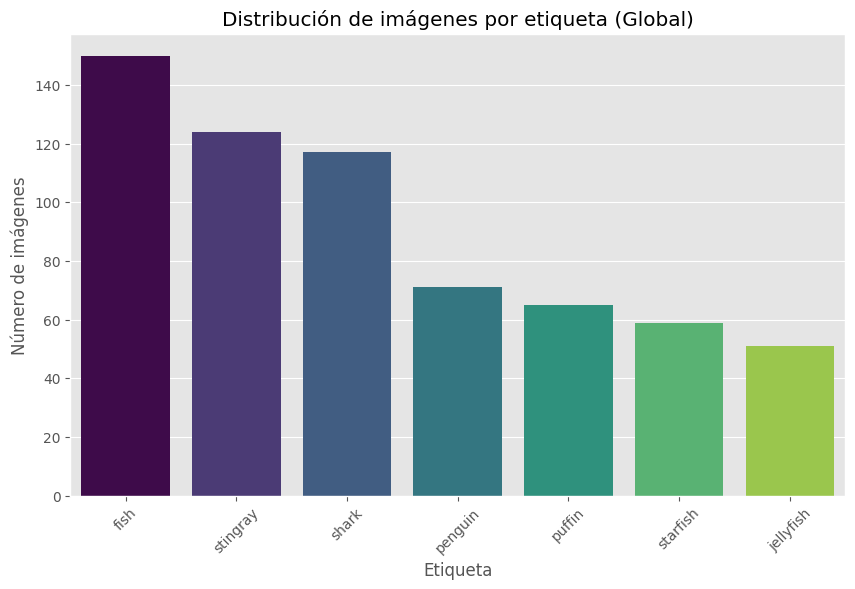

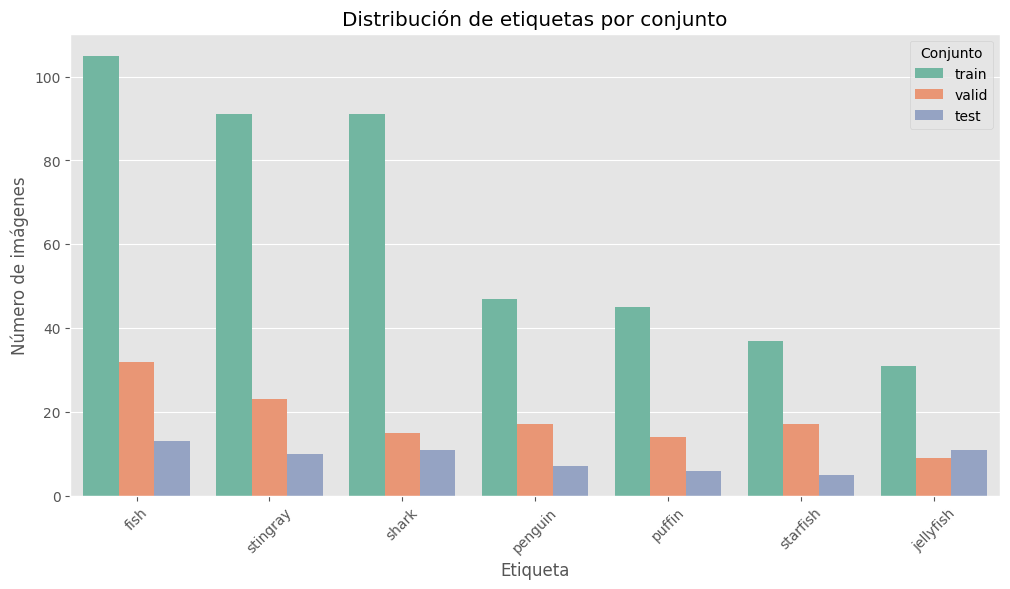


Proporción de cada etiqueta en cada conjunto:


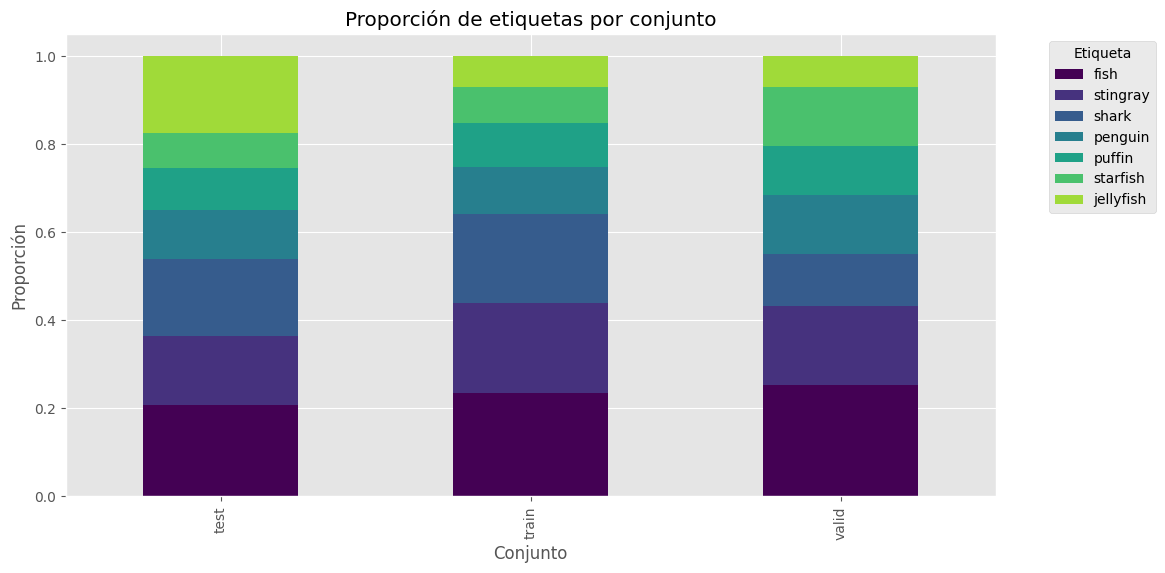

In [7]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.cm as cm
import matplotlib.colors as mcolors

# Función para cargar las nuevas etiquetas por cada conjunto
def load_new_labels(data_dir, set_name):
    annotation_path = os.path.join(data_dir, set_name, "annotations.csv")
    filenames, labels = annotation_to_labels(annotation_path)
    df_labels = pd.DataFrame({"filename": filenames, "label": labels})
    df_labels["dataset"] = set_name
    return df_labels

# Cargar etiquetas de todos los conjuntos
df_new_labels = pd.concat([load_new_labels("data", set_name) for set_name in ["train", "valid", "test"]], ignore_index=True)

# Mostrar estadísticas básicas
print("═" * 50)
print("ESTADÍSTICAS BÁSICAS CON NUEVAS ETIQUETAS")
print("═" * 50)
print(f"Total de imágenes etiquetadas: {df_new_labels.shape[0]}")
print(f"Imágenes únicas: {df_new_labels['filename'].nunique()}")
print(f"Etiquetas generadas: {df_new_labels['label'].unique()}")

# Conteo y orden de etiquetas
labels_count = df_new_labels['label'].value_counts().sort_values(ascending=False)
print("\nConteo de imágenes por etiqueta (orden ascendente):")
print(labels_count)

# Generar colores consistentes para las etiquetas
ordered_classes = labels_count.index.tolist()
color_dict = {label: mcolors.to_hex(cm.viridis(i/len(ordered_classes))) for i, label in enumerate(ordered_classes)}

# Gráfico de distribución global
plt.figure(figsize=(10, 6))
sns.barplot(
    data=pd.DataFrame({'label': labels_count.index, 'count': labels_count.values}),
    x="label", y="count", hue="label", palette=color_dict, dodge=False, order=ordered_classes
)
plt.title("Distribución de imágenes por etiqueta (Global)")
plt.xlabel("Etiqueta")
plt.ylabel("Número de imágenes")
plt.xticks(rotation=45)
plt.show()

# Distribución por conjunto
plt.figure(figsize=(12, 6))
sns.countplot(data=df_new_labels, x="label", hue="dataset", palette="Set2", order=ordered_classes)
plt.title("Distribución de etiquetas por conjunto")
plt.xlabel("Etiqueta")
plt.ylabel("Número de imágenes")
plt.xticks(rotation=45)
plt.legend(title="Conjunto")
plt.show()

# Análisis de proporciones
df_prop = pd.merge(
    df_new_labels.groupby(["dataset", "label"]).size().reset_index(name="count"),
    df_new_labels.groupby("dataset").size().reset_index(name="total"),
    on="dataset"
)
df_prop["proporcion"] = df_prop["count"] / df_prop["total"]

print("\nProporción de cada etiqueta en cada conjunto:")
df_prop.pivot(index="dataset", columns="label", values="proporcion")[ordered_classes].plot(
    kind="bar", stacked=True,
    color=[color_dict[label] for label in ordered_classes],
    figsize=(12, 6)
)
plt.title("Proporción de etiquetas por conjunto")
plt.xlabel("Conjunto")
plt.ylabel("Proporción")
plt.legend(title="Etiqueta", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


Con este output se puede ver que el desbalanceo que parecía haber antes de reetiquetar no es tan grande, por ejemplo, cuando una imagen se etiqueta como "fish" es porque hay muchos peces en la imagen, que contaban en la anterior evaluación.

Dicho esto, si que se observa un desbalance que puede ser o asumido o tratado. Hay que tener en cuenta que se cuenta con pocos datos entonces quizá sea interesante admitir un pequeño desbalanceo.

# PREPARACIÓN DE DATOS

De nuestros tensores que son rutas de imágenes extraemos etiquetas, esta es una operación ligera, por lo que la mantenemos en caché y realizamos toda la normalización, es decir, convertimos a codificación onehot.

## Create tf.data.Dataset

### Función get_jpg_ds

Crea un diccionario de datasets de TensorFlow, uno para cada conjunto de datos,
conteniendo las rutas a todas las imágenes JPG de cada conjunto.

In [8]:
# Lista de nombres de los conjuntos de datos que se van a procesar
set_names = ["train", "valid", "test"]

# Directorio raíz que contiene todos los conjuntos de datos
data_dir = "data"

# Función para crear datasets de TensorFlow a partir de archivos JPG
def get_jpg_ds(set_names, data_dir):
    """
    Crea un diccionario de datasets de TensorFlow, uno para cada conjunto de datos,
    conteniendo las rutas a todas las imágenes JPG de cada conjunto.

    Parámetros:
    -----------
    set_names : list
        Lista de nombres de los conjuntos de datos (ej: ["train", "valid", "test"])
    data_dir : str
        Directorio raíz que contiene todos los conjuntos de datos

    Retorna:
    --------
    dict
        Diccionario donde las claves son los nombres de los conjuntos y los valores
        son objetos tf.data.Dataset que contienen las rutas a las imágenes
    """
    return {
        # Para cada nombre en la lista (train, valid, test)...
        name: tf.data.Dataset.list_files(
            # Construye un patrón de búsqueda que encontrará todos los archivos .jpg
            # en cualquier subdirectorio del conjunto de datos.
            # Ejemplo: "data/train/*/*.jpg" encontrará todas las imágenes .jpg en
            # subdirectorios como data/train/fish/..., data/train/shark/..., etc.
            os.path.join(data_dir, name) + os.sep + '*/*.jpg',

            # No mezclar el orden de los archivos (facilita la depuración)
            # En la práctica, se suele establecer en True para entrenamiento
            shuffle=False,
        )
        # Crea una entrada en el diccionario para cada conjunto en set_names
        for name in set_names
    }

# Crear los datasets utilizando la función definida
ds = get_jpg_ds(set_names, data_dir)

# Muestra el diccionario de datasets (contiene 3 datasets: train, valid y test)
ds


{'train': <_TensorSliceDataset element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>,
 'valid': <_TensorSliceDataset element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>,
 'test': <_TensorSliceDataset element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>}

In [9]:
# Definición del mapeo entre índices numéricos y clases (en formato binario)
# Esto sirve como un diccionario para convertir entre la representación numérica y textual de cada clase
class_mapping = {
    0: b"fish",
    1: b"jellyfish",
    2: b"penguin",
    3: b"puffin",
    4: b"shark",
    5: b"starfish",
    6: b"stingray",
}

# Creación de una tabla hash estática en TensorFlow para realizar búsquedas eficientes
# Esta tabla mapea nombres de clases a sus índices correspondientes
# Permite convertir rápidamente las etiquetas de texto a valores numéricos durante el procesamiento
class_lookup_table = tf.lookup.StaticHashTable(
    tf.lookup.KeyValueTensorInitializer(
        keys=tf.constant(list(class_mapping.values())),  # Nombres de clases como claves
        values=tf.constant(list(class_mapping.keys()), dtype=tf.int64)  # Índices como valores
    ),
    default_value=-1  # Valor que se devuelve si no se encuentra la clave
)

# Función para extraer y procesar la etiqueta de una imagen a partir de su ruta
def get_label(image_path):
    # Extrae el nombre de la carpeta (que es la clase) de la ruta de la imagen
    # Ejemplo: "data/train/fish/image.jpg" -> "fish"
    label = tf.strings.split(image_path, os.sep)[-2]

    # Convierte el nombre de la clase a su índice correspondiente usando la tabla de búsqueda
    label = class_lookup_table.lookup(label)

    # Convierte el índice a un vector one-hot
    # Ejemplo: si label=0 (fish), one_hot = [1,0,0,0,0,0,0]
    label = tf.one_hot(label, len(class_mapping))

    return label

# Función para aplicar una transformación a todos los conjuntos de datos
# Recibe un diccionario de datasets y una función para aplicar a cada uno
def update_ds(ds, func):
    # Itera sobre cada clave (train, valid, test) en el diccionario
    for key in ds.keys():
        # Aplica la función de transformación a cada elemento del dataset
        ds[key] = ds[key].map(
            func,
            num_parallel_calls=tf.data.AUTOTUNE  # Optimiza el rendimiento permitiendo paralelismo
        )

# Nombres de los conjuntos de datos
set_names = ["train", "valid", "test"]
# Directorio raíz donde se encuentran los datos
data_dir = "data"

# Obtiene los datasets de imágenes JPG (función get_jpg_ds no mostrada en el código)
ds = get_jpg_ds(set_names, data_dir)

# Actualiza cada dataset para convertir cada elemento en una tupla (imagen, etiqueta)
# La función lambda toma una ruta de imagen y devuelve una tupla con la ruta y su etiqueta
update_ds(ds, lambda x: (x, get_label(x)))

# Prueba el dataset extrayendo el primer elemento del conjunto de prueba
# Esto permite verificar que el procesamiento de datos funciona correctamente
ds["test"].as_numpy_iterator().next()


(b'data/test/fish/IMG_2371_jpeg_jpg.rf.54505f60b6706da151c164188c305849.jpg',
 array([1., 0., 0., 0., 0., 0., 0.], dtype=float32))

In [10]:
# Función para cargar y decodificar una imagen a partir de su ruta
def get_image(image_path):
    """
    Carga una imagen desde una ruta de archivo y la decodifica como un tensor RGB.

    Parámetros:
    -----------
    image_path : tf.Tensor (string)
        Ruta al archivo de imagen

    Retorna:
    --------
    tf.Tensor (float32)
        Tensor 3D que representa la imagen decodificada en formato RGB
    """
    # Lee el contenido del archivo como un tensor de bytes
    # Esta operación no carga la imagen en memoria, solo lee los bytes del archivo
    image = tf.io.read_file(image_path)

    # Decodifica los bytes como una imagen JPEG con 3 canales de color (RGB)
    # El resultado es un tensor 3D con forma [altura, anchura, 3]
    # Los valores están en el rango [0, 255]
    image = tf.image.decode_jpeg(image, channels=3)

    return image


# Obtener las rutas de imágenes para todos los conjuntos de datos
ds = get_jpg_ds(set_names, data_dir)

# Transformar el dataset para que cada elemento sea una tupla (ruta_imagen, etiqueta)
# - 'x' es la ruta de la imagen
# - 'get_label(x)' obtiene la etiqueta one-hot a partir de la ruta
update_ds(ds, lambda x: (x, get_label(x)))

# Transformar el dataset para cargar las imágenes reales en lugar de solo las rutas
# - 'x' es la ruta de la imagen
# - 'y' es la etiqueta one-hot que ya teníamos
# - 'get_image(x)' carga y decodifica la imagen desde la ruta
update_ds(ds, lambda x, y: (get_image(x), y))


### Ejemplo de pez

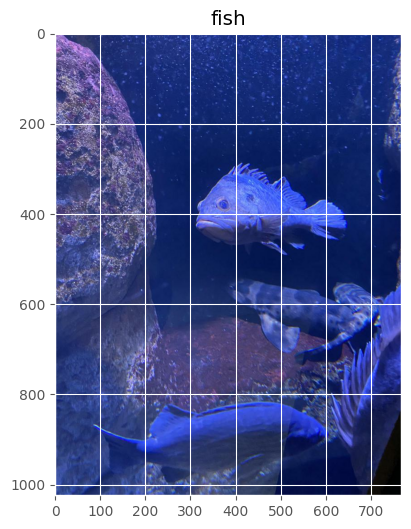

In [11]:
import matplotlib.pyplot as plt

# Obtiene un ejemplo (imagen, etiqueta) del conjunto de prueba
# - as_numpy_iterator() convierte el dataset de TensorFlow a un iterador numpy
# - next() extrae la primera tupla del iterador, separando la imagen y la etiqueta
image, label = next(ds["test"].as_numpy_iterator())

# Visualiza la imagen usando matplotlib
plt.imshow(image)

# Crea un título para la imagen que muestra su clase:
# 1. np.argmax(label) encuentra el índice con el valor más alto en el vector one-hot
#    (ej: si label=[0,0,1,0,0,0,0], np.argmax(label)=2)
# 2. class_mapping[índice] obtiene el nombre de la clase en formato binario
#    (ej: class_mapping[2] = b'penguin')
# 3. .decode() convierte del formato binario a string normal
#    (ej: b'penguin' → 'penguin')
plt.title(class_mapping[np.argmax(label)].decode())

# Muestra la imagen con su título en una ventana gráfica
plt.show()


In [12]:
# Inicia el pipeline obteniendo las rutas a las imágenes de cada conjunto (train, valid, test)
ds = get_jpg_ds(set_names, data_dir)

# PASO 1: Agregar etiquetas a los datos
# Transforma cada ruta de imagen para crear una tupla (ruta_imagen, etiqueta)
# - La función get_label() extrae la clase de la estructura de directorios y la convierte a formato one-hot
update_ds(ds, lambda x: (x, get_label(x)))

# PASO 2: Cargar el contenido real de las imágenes
# Transforma cada elemento para reemplazar la ruta por el tensor de la imagen
# - La función get_image() lee y decodifica la imagen desde su ruta
update_ds(ds, lambda x, y: (get_image(x), y))

# PASO 3: Normalizar las dimensiones de todas las imágenes
# Aplica redimensionamiento con relleno o recorte para lograr un tamaño uniforme
# - tf.image.resize_with_crop_or_pad mantiene la relación de aspecto original:
#   * Si la imagen es más pequeña que 1024x1024, añade espacio en negro (padding)
#   * Siempre centra la imagen original en el resultado final
update_ds(ds, lambda x, y: (tf.image.resize_with_crop_or_pad(x, 1024, 1024), y))


ds

{'train': <_ParallelMapDataset element_spec=(TensorSpec(shape=(1024, 1024, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(7,), dtype=tf.float32, name=None))>,
 'valid': <_ParallelMapDataset element_spec=(TensorSpec(shape=(1024, 1024, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(7,), dtype=tf.float32, name=None))>,
 'test': <_ParallelMapDataset element_spec=(TensorSpec(shape=(1024, 1024, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(7,), dtype=tf.float32, name=None))>}

### Función resize_and_keep_uint8

Redimensiona una imagen a un tamaño específico, manteniendo el tipo de datos uint8.


In [13]:
# Función personalizada para redimensionar imágenes manteniendo el tipo de datos uint8
def resize_and_keep_uint8(image, height=64, width=64):
    """
    Redimensiona una imagen a un tamaño específico, manteniendo el tipo de datos uint8.

    Parámetros:
    -----------
    image : tf.Tensor
        Imagen de entrada en formato uint8 (valores de 0 a 255)
    height : int, opcional (predeterminado=64)
        Altura deseada para la imagen redimensionada
    width : int, opcional (predeterminado=64)
        Anchura deseada para la imagen redimensionada

    Retorna:
    --------
    tf.Tensor
        Imagen redimensionada en formato uint8
    """
    # Redimensiona la imagen (esto convierte automáticamente a float32)
    resized_image = tf.image.resize(image, [height, width])

    # Restringe los valores al rango [0, 255] para evitar desbordamientos
    # Esto es necesario porque el proceso de interpolación durante el redimensionamiento
    # puede generar valores fuera del rango válido
    resized_image = tf.clip_by_value(resized_image, 0, 255)

    # Convierte de vuelta a uint8 (enteros de 8 bits sin signo)
    resized_image = tf.cast(resized_image, tf.uint8)

    return resized_image

# Inicia el pipeline con las rutas a imágenes
ds = get_jpg_ds(set_names, data_dir)

# PASO 1: Añadir etiquetas
update_ds(ds, lambda x: (x, get_label(x)))

# PASO 2: Cargar imágenes desde rutas
update_ds(ds, lambda x, y: (get_image(x), y))

# PASO 3: Normalizar dimensiones con padding/cropping manteniendo relación de aspecto
update_ds(ds, lambda x, y: (tf.image.resize_with_crop_or_pad(x, 1024, 1024), y))

# PASO 4: Redimensionar a 64x64 manteniendo el formato uint8
update_ds(ds, lambda x, y: (resize_and_keep_uint8(x), y))


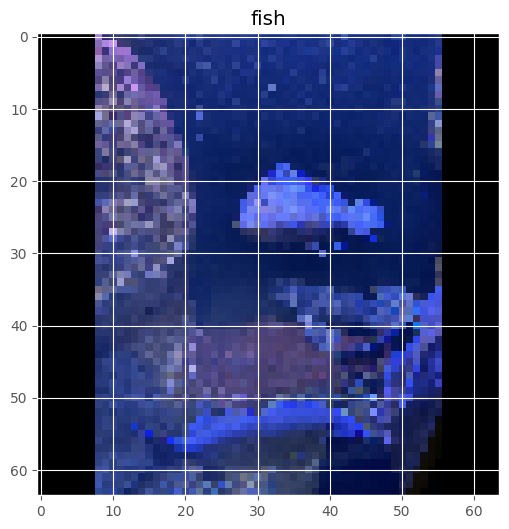

In [ ]:
# Extrae la primera muestra del conjunto de prueba
# - as_numpy_iterator() convierte el dataset de TensorFlow a un iterador de NumPy
# - next() obtiene el primer elemento del iterador, que es una tupla (imagen, etiqueta)
image, label = next(ds["test"].as_numpy_iterator())

# Visualiza la imagen con matplotlib
plt.imshow(image)

# Construye el título de la figura que muestra la clase de la imagen
# 1. np.argmax(label): encuentra el índice del valor máximo en el vector one-hot
#    (por ejemplo, si label=[0,0,0,1,0,0,0], devuelve 3)
# 2. class_mapping[índice]: obtiene el nombre binario de la clase
#    (por ejemplo, class_mapping[3] = b'puffin')
# 3. .decode(): convierte el string binario a string normal
#    (b'puffin' → 'puffin')
plt.title(class_mapping[np.argmax(label)].decode())

# Muestra la figura con la imagen y su título
plt.show()


In [15]:
# Inicializa el dataset con las rutas de archivos
ds = get_jpg_ds(set_names, data_dir)

# Transforma los elementos para incluir etiquetas basadas en la estructura de directorios
update_ds(ds, lambda x: (x, get_label(x)))

# Carga las imágenes reales desde las rutas
update_ds(ds, lambda x, y: (get_image(x), y))

# Normaliza las dimensiones a 1024x1024 manteniendo la relación de aspecto original
# mediante padding o recorte
update_ds(ds, lambda x, y: (tf.image.resize_with_crop_or_pad(x, 1024, 1024), y))

# Redimensiona las imágenes a un tamaño menor (predeterminado 64x64)
# conservando el tipo de datos uint8
update_ds(ds, lambda x, y: (resize_and_keep_uint8(x), y))

# Muestra el objeto dataset resultante
ds


{'train': <_ParallelMapDataset element_spec=(TensorSpec(shape=(64, 64, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(7,), dtype=tf.float32, name=None))>,
 'valid': <_ParallelMapDataset element_spec=(TensorSpec(shape=(64, 64, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(7,), dtype=tf.float32, name=None))>,
 'test': <_ParallelMapDataset element_spec=(TensorSpec(shape=(64, 64, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(7,), dtype=tf.float32, name=None))>}

# PREPARACIÓN DEL MODELO

In [16]:
# Imprime el número de imágenes en los conjuntos de entrenamiento y validación
print(len(ds["train"]), len(ds["valid"]))

# Función de aumentación de datos para mejorar la generalización del modelo
def augment(image, label):
    # Aplica volteo horizontal aleatorio a las imágenes
    image = tf.image.random_flip_left_right(image)
    return image, label

# Configuración de optimización y tamaño de batch
AUTOTUNE = tf.data.AUTOTUNE  # Permite a TensorFlow optimizar automáticamente el paralelismo
BATCH_SIZE = 32  # Número de imágenes procesadas en cada iteración

# Pipeline de datos para entrenamiento con múltiples optimizaciones
ds_fit = (
    ds["train"]
    .cache()                                   # Almacena en caché para acelerar epochs posteriores
    .map(augment, num_parallel_calls=AUTOTUNE) # Aplica aumentación de datos en paralelo
    .shuffle(len(ds["train"]))                 # Mezcla todas las muestras
    .batch(BATCH_SIZE)                         # Agrupa en lotes de 32 imágenes
    .prefetch(AUTOTUNE)                        # Precargar el siguiente batch mientras se procesa el actual
)

# Pipeline de datos para validación (sin aumentación)
ds_val = (
    ds["valid"]
    .cache()                                   # Almacena en caché para consistencia
    .batch(BATCH_SIZE)                         # Agrupa en lotes de 32 imágenes
    .prefetch(tf.data.AUTOTUNE)                # Precargar el siguiente batch
)


447 127


In [17]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Callback para reducir automáticamente la tasa de aprendizaje cuando el entrenamiento se estanca
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',    # Métrica a vigilar (pérdida en validación)
    factor=0.2,            # Factor de reducción (multiplica LR actual por 0.2)
    patience=4,            # Espera 4 épocas sin mejora antes de reducir
    min_lr=0.0001          # No reduce la tasa de aprendizaje por debajo de este valor
)

# Número de épocas a esperar antes de detener el entrenamiento si no hay mejora
epoch_wait = 10

# Callback para detener el entrenamiento si no hay mejora en la pérdida de validación
early_stopping = EarlyStopping(
    monitor='val_loss',         # Métrica a vigilar (pérdida en validación)
    verbose=1,                  # Muestra mensajes informativos durante el entrenamiento
    patience=epoch_wait,        # Espera 10 épocas sin mejora antes de detener
    restore_best_weights=True   # Restaura los pesos del modelo al mejor punto encontrado
)

# Lista de callbacks que se pasará al método fit() del modelo
callbacks = [early_stopping, reduce_lr]



In [18]:
# Establecer la semilla global
seed_value = 42
tf.random.set_seed(seed_value)

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout, ZeroPadding2D
from tensorflow.keras import regularizers
from tensorflow.keras.applications import MobileNetV2, InceptionV3, ResNet50, VGG16, VGG19, DenseNet121, DenseNet169, DenseNet201

# Parámetros de configuración del modelo
l2_reg_strength = 0.01  # Factor de regularización L2 para evitar sobreajuste
num_classes = 7        # Número total de clases (fish, jellyfish, penguin, etc.)


# Construcción de la arquitectura del modelo CNN
model = Sequential([
    # --- Comentados: Capas de aumento de datos (ya se maneja en el pipeline) ---
    # tf.keras.layers.RandomFlip("horizontal_and_vertical"),  # Flips aleatorios
    # tf.keras.layers.RandomRotation(0.2),                    # Rotación aleatoria
    # tf.keras.layers.RandomZoom(0.2),                        # Zoom aleatorio
    # tf.keras.layers.RandomContrast(0.2),                    # Ajuste de contraste
    # tf.keras.layers.RandomTranslation(height_factor=0.1, width_factor=0.1),

    # --- BLOQUE 1: Primera sección convolucional ---
    ZeroPadding2D(padding=(4, 4)),          # Añade bordes de ceros para preservar información en bordes
    Conv2D(32, (3, 3), activation='relu'),  # 32 filtros de 3x3 con activación ReLU
    BatchNormalization(),                   # Normaliza las activaciones para acelerar convergencia

    # --- BLOQUE 2: Segunda sección convolucional ---
    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(l2_reg_strength)),  # Con regularización
    MaxPooling2D((4, 4)),                   # Reduce dimensiones espaciales 4x
    Dropout(0.25),                          # Desactiva aleatoriamente 25% de neuronas (evita sobreajuste)

    # --- BLOQUE 3: Tercera sección convolucional ---
    BatchNormalization(),                   # Estabiliza entrenamiento
    ZeroPadding2D(padding=(2, 2)),          # Preserva dimensiones espaciales
    Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(l2_reg_strength)),
    BatchNormalization(),                   # Normalización adicional

    # --- BLOQUE 4: Cuarta sección convolucional ---
    Conv2D(128, (3, 3), activation='relu'), # 128 filtros adicionales
    MaxPooling2D((2, 2)),                   # Reducción espacial 2x
    Dropout(0.25),                          # Prevención de sobreajuste

    # --- BLOQUE 5: Clasificación (fully connected) ---
    Flatten(),                              # Convierte mapa de características 2D → vector 1D
    Dense(512, activation='relu'),          # Capa densa con 512 neuronas
    BatchNormalization(),                   # Normalización final
    Dropout(0.5),                           # Dropout agresivo (50%) antes de clasificación
    Dense(num_classes, activation='softmax') # Capa de salida: una neurona por clase con softmax
])

# Crea una copia exacta del modelo (arquitectura y pesos) para experimentación posterior
model_test = tf.keras.models.clone_model(model)


# Compilación del modelo con los parámetros requeridos
model.compile(
    optimizer='rmsprop',                # Optimizador RMSprop (requerido según las especificaciones)
    loss='categorical_crossentropy',    # Función de pérdida para clasificación multiclase
    metrics=[
        "accuracy",                     # Fracción de predicciones correctas
        "precision",                    # Verdaderos positivos / (Verdaderos positivos + Falsos positivos)
        "recall",                       # Verdaderos positivos / (Verdaderos positivos + Falsos negativos)
        # --- Métricas alternativas (comentadas) ---
        # "f1_score"                    # Media armónica de precisión y recall
        # tf.keras.metrics.F1Score(name='f1_score')
    ]
)

# Entrenamiento del modelo
history = model.fit(
    ds_fit,                # Dataset de entrenamiento (con augmentation)
    epochs=100,            # Máximo número de épocas
    validation_data=ds_val, # Dataset de validación
    callbacks=callbacks     # Lista de callbacks (early stopping, reducción de LR)
)

# Análisis post-entrenamiento
import numpy as np

# Identifica la época con mejor rendimiento en validación
best_epoch = np.argmax(history.history["val_accuracy"])  # Índice de la mejor precisión
best_val_acc = history.history["val_accuracy"][best_epoch]  # Valor de la mejor precisión

# Muestra resultados del mejor punto de entrenamiento
print(f"La mejor época fue: {best_epoch + 1} con val_accuracy: {best_val_acc:.4f}")


Epoch 1/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.3480 - loss: 3.8468 - precision: 0.3800 - recall: 0.2771 - val_accuracy: 0.2835 - val_loss: 17.0360 - val_precision: 0.2778 - val_recall: 0.2756 - learning_rate: 0.0010
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - accuracy: 0.5574 - loss: 2.6710 - precision: 0.6263 - recall: 0.5038 - val_accuracy: 0.2598 - val_loss: 12.2878 - val_precision: 0.2705 - val_recall: 0.2598 - learning_rate: 0.0010
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.6486 - loss: 2.4009 - precision: 0.7110 - recall: 0.5779 - val_accuracy: 0.1969 - val_loss: 9.3387 - val_precision: 0.2033 - val_recall: 0.1969 - learning_rate: 0.0010
Epoch 4/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.6641 - loss: 2.1841 - precision: 0.7294 - recall: 0.6243 - val_accuracy: 0.1811 - val_loss: 8.6801 - val_precision: 0.1917 - val_recall: 0.1811 - learning_rate: 0.0010
Epoch 5/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy

In [20]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout, ZeroPadding2D, RandomRotation
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Sequential

def build_model(conv_sizes, kernel_sizes, pooling_sizes, n_convs, lr_patience, num_classes, lr_factor = 0.2):
    """
    Construye un modelo CNN personalizable para clasificación de imágenes.

    Parámetros:
    -----------
    conv_sizes: lista - Número de filtros para cada capa convolucional
                        (ej: [32, 64, 128])
    kernel_sizes: lista - Tamaños de los kernels para cada capa convolucional
                          (ej: [(3,3), (3,3), (3,3)])
    pooling_sizes: lista - Tamaños de pooling para cada capa convolucional
                           (None si no se aplica pooling)
    n_convs: int - Número total de bloques convolucionales a crear
    lr_patience: int - Número de épocas sin mejora antes de reducir la tasa de aprendizaje
    num_classes: int - Número de clases para la clasificación
    """

    # --- Configuración de callbacks para optimizar el entrenamiento ---
    # ReduceLROnPlateau: Reduce la tasa de aprendizaje cuando el modelo se estanca
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',    # Métrica a vigilar
        factor=lr_factor,            # Multiplicador para reducir LR (LR * 0.2)
        patience=lr_patience,  # Épocas a esperar sin mejora
        min_lr=0.0001          # Límite inferior para la tasa de aprendizaje
    )

    # EarlyStopping: Detiene el entrenamiento cuando no hay mejora
    early_stopping = EarlyStopping(
        monitor='val_loss',         # Métrica a vigilar
        verbose=1,                  # Muestra mensajes de progreso
        patience=10,                # Épocas a esperar sin mejora antes de parar
        restore_best_weights=True   # Recupera los mejores pesos encontrados
    )

    # Lista de callbacks para pasar al método fit()
    callbacks = [early_stopping, reduce_lr]

    # --- ARQUITECTURA DEL MODELO ---
    # 1. Capas de entrada: Padding inicial para preservar información de bordes
    input_layers = [ZeroPadding2D(padding=(4, 4))]

    # 2. Capas ocultas: Bloques convolucionales configurables
    hidden_layers = []
    for i in range(n_convs):
        # Capa convolucional con tamaño y número de filtros configurables
        hidden_layers.append(Conv2D(conv_sizes[i], kernel_sizes[i], activation='relu'))

        # Normalización por lotes para estabilizar y acelerar el entrenamiento
        hidden_layers.append(BatchNormalization())

        # Capa de pooling opcional (si se especifica en pooling_sizes)
        if pooling_sizes[i] is not None:
            hidden_layers.append(MaxPooling2D(pooling_sizes[i]))

        # Dropout para prevenir sobreajuste
        hidden_layers.append(Dropout(0.25))

    # 3. Capas de salida: Clasificación final
    output_layers = [
        Flatten(),                           # Convierte mapa de características a vector
        Dense(512, activation='relu'),       # Capa densa con 512 neuronas
        BatchNormalization(),                # Normalización final
        Dropout(0.5),                        # Dropout fuerte antes de la clasificación
        Dense(num_classes, activation='softmax')  # Capa de salida (una por clase)
    ]

    # Combinación de todas las capas en un modelo secuencial
    model = Sequential(input_layers + hidden_layers + output_layers)

    # --- COMPILACIÓN DEL MODELO ---
    # Configura el proceso de entrenamiento
    model.compile(
        optimizer='rmsprop',                # Optimizador requerido en la práctica
        loss='categorical_crossentropy',    # Función de pérdida para clasificación multiclase
        metrics=[
            "accuracy",                     # Precisión global
            "precision",                    # Precisión (TP/(TP+FP))
            "recall",                       # Exhaustividad (TP/(TP+FN))
        ]
    )
    return model


# Arquitecturas fine-tuning del pretrain

## Definición de modelos

In [28]:
# Importación necesaria para la visualización del modelo
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
from IPython.display import Image, display

# Definición de las diferentes configuraciones para fine-tuning
config_models = [
    {
        # Configuración 1: Modelo profundo con 4 capas
        "name": "Modelo profundo (4 capas)",
        "conv_sizes": [32, 64, 128, 128],
        "kernel_sizes": [(3, 3), (4, 4), (3, 3), (3, 3)],
        "pooling_sizes": [None, (2, 2), None, (2, 2)],
        "lr_factor": 0.2,
        "lr_patience": 5
    },
    {
        # Configuración 2: Modelo con 3 capas y kernels más grandes
        "name": "Modelo con kernels grandes (3 capas)",
        "conv_sizes": [48, 96, 192],
        "kernel_sizes": [(5, 5), (4, 4), (3, 3)],
        "pooling_sizes": [(2, 2), (2, 2), (2, 2)],
        "lr_factor": 0.1,
        "lr_patience": 3
    },
    {
        # Configuración 3: Modelo con 5 capas y pooling específico
        "name": "Modelo amplio (5 capas)",
        "conv_sizes": [24, 48, 96, 128, 256],
        "kernel_sizes": [(3, 3), (3, 3), (3, 3), (3, 3), (3, 3)],
        "pooling_sizes": [(2, 2), None, (2, 2), None, (2, 2)],
        "lr_factor": 0.3,
        "lr_patience": 8
    }
]

# Parámetro común para todos los modelos
num_classes = 7

## Entrenamiento de modelos


Entrenando Modelo profundo (4 capas) (Modelo 1/3)

Configuraciones del modelo 1:
- Número de capas convolucionales: 4
- Tamaños de filtros: [32, 64, 128, 128]
- Tamaños de kernel: [(3, 3), (4, 4), (3, 3), (3, 3)]
- Configuración de pooling: [None, (2, 2), None, (2, 2)]
- Factor de reducción LR: 0.2
- Paciencia para reducción LR: 5

Arquitectura del modelo 1 (visualización horizontal):


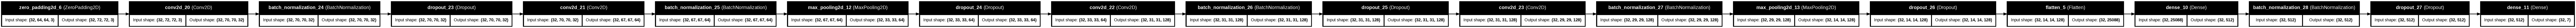

Epoch 1/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 22s 962ms/step - accuracy: 0.3495 - loss: 2.6042 - precision: 0.4023 - recall: 0.3017 - val_accuracy: 0.1890 - val_loss: 16.5786 - val_precision: 0.1920 - val_recall: 0.1890 - learning_rate: 0.0010
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.6103 - loss: 1.2814 - precision: 0.6574 - recall: 0.5417 - val_accuracy: 0.2756 - val_loss: 6.8577 - val_precision: 0.2750 - val_recall: 0.2598 - learning_rate: 0.0010
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.6839 - loss: 0.9449 - precision: 0.7539 - recall: 0.6230 - val_accuracy: 0.2992 - val_loss: 6.7323 - val_precision: 0.3248 - val_recall: 0.2992 - learning_rate: 0.0010
Epoch 4/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.7185 - loss: 0.9004 - precision: 0.7506 - recall: 0.6705 - val_accuracy: 0.3071 - val_loss: 3.9482 - val_precision: 0.3058 - val_recall: 0.2913 - learning_rate: 0.0010
Epoch 5/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accurac

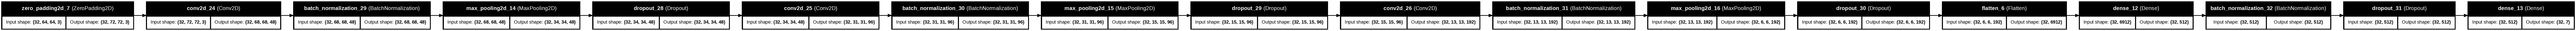

Epoch 1/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 15s 511ms/step - accuracy: 0.3330 - loss: 2.8267 - precision: 0.3426 - recall: 0.2702 - val_accuracy: 0.2126 - val_loss: 48.3840 - val_precision: 0.2126 - val_recall: 0.2126 - learning_rate: 0.0010
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.5963 - loss: 1.3986 - precision: 0.6401 - recall: 0.5314 - val_accuracy: 0.1417 - val_loss: 20.4094 - val_precision: 0.1349 - val_recall: 0.1339 - learning_rate: 0.0010
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.6091 - loss: 1.1986 - precision: 0.6754 - recall: 0.5551 - val_accuracy: 0.2677 - val_loss: 11.8975 - val_precision: 0.2720 - val_recall: 0.2677 - learning_rate: 0.0010
Epoch 4/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.6432 - loss: 1.0631 - precision: 0.6804 - recall: 0.5935 - val_accuracy: 0.2835 - val_loss: 10.7519 - val_precision: 0.2720 - val_recall: 0.2677 - learning_rate: 0.0010
Epoch 5/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accu

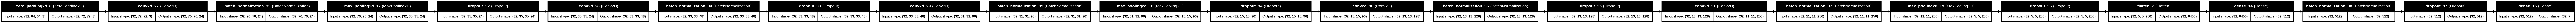

Epoch 1/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 20s 689ms/step - accuracy: 0.2618 - loss: 2.8282 - precision: 0.3110 - recall: 0.2220 - val_accuracy: 0.1339 - val_loss: 16.7396 - val_precision: 0.1360 - val_recall: 0.1339 - learning_rate: 0.0010
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.5598 - loss: 1.4493 - precision: 0.6324 - recall: 0.4973 - val_accuracy: 0.1811 - val_loss: 6.6113 - val_precision: 0.1885 - val_recall: 0.1811 - learning_rate: 0.0010
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5930 - loss: 1.2292 - precision: 0.6487 - recall: 0.5383 - val_accuracy: 0.2205 - val_loss: 6.3806 - val_precision: 0.2261 - val_recall: 0.2047 - learning_rate: 0.0010
Epoch 4/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.6319 - loss: 1.1177 - precision: 0.6873 - recall: 0.5776 - val_accuracy: 0.2913 - val_loss: 3.4674 - val_precision: 0.3063 - val_recall: 0.2677 - learning_rate: 0.0010
Epoch 5/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accurac

In [29]:
# Lista para almacenar resultados
model_results = []

# Creación de un pipeline optimizado para el conjunto de prueba
ds_eval = (
    ds["test"].cache()         # Almacena en memoria el conjunto de prueba
    .batch(BATCH_SIZE)         # Agrupa en lotes de 64 imágenes
    .prefetch(AUTOTUNE)        # Precarga el siguiente lote mientras se procesa el actual
)

# Ejecutar proceso de fine-tuning para cada configuración
for i, config in enumerate(config_models):
    print(f"\n{'='*50}")
    print(f"Entrenando {config['name']} (Modelo {i+1}/{len(config_models)})")
    print(f"{'='*50}")

    # Obtener parámetros de la configuración actual
    conv_sizes = config["conv_sizes"]
    kernel_sizes = config["kernel_sizes"]
    pooling_sizes = config["pooling_sizes"]
    n_convs = len(kernel_sizes)
    lr_patience = config["lr_patience"]
    lr_factor = config["lr_factor"]

    # Mostrar configuración detallada
    print(f"\nConfiguraciones del modelo {i+1}:")
    print(f"- Número de capas convolucionales: {n_convs}")
    print(f"- Tamaños de filtros: {conv_sizes}")
    print(f"- Tamaños de kernel: {kernel_sizes}")
    print(f"- Configuración de pooling: {pooling_sizes}")
    print(f"- Factor de reducción LR: {lr_factor}")
    print(f"- Paciencia para reducción LR: {lr_patience}")

    # Construir el modelo con la configuración actual
    model = build_model(conv_sizes, kernel_sizes, pooling_sizes, n_convs,
                        lr_patience, num_classes, lr_factor)

    # Visualizar la arquitectura del modelo con plot_model
    # Crear un lote de datos ficticio para que el modelo infiera las formas
    batch = next(iter(ds_fit))
    model(batch[0])  # Ejecuta una pasada hacia adelante para construir el modelo

    # Genera y guarda la visualización vertical
    plot_filename_v = f'model_{i+1}_vertical.png'
    plot_model(model, to_file=plot_filename_v, show_shapes=True,
               show_layer_names=True, rankdir='TB', dpi=150)

    # Genera y guarda la visualización horizontal
    plot_filename_h = f'model_{i+1}_horizontal.png'
    plot_model(model, to_file=plot_filename_h, show_shapes=True,
               show_layer_names=True, rankdir='LR', dpi=150)

    # Mostrar las imágenes generadas
    print(f"\nArquitectura del modelo {i+1} (visualización horizontal):")
    display(Image(filename=plot_filename_h))

    # Entrenar el modelo
    history = model.fit(
        ds_fit,
        epochs=100,
        validation_data=ds_val,
        callbacks=callbacks,
        verbose=1
    )

    # Evaluar el modelo en el conjunto de prueba
    print(f"\nEvaluando modelo {i+1} en conjunto de prueba...")
    test_metrics = model.evaluate(ds_eval)

    # Encontrar la mejor época
    best_epoch = np.argmax(history.history["val_accuracy"])
    best_val_acc = history.history["val_accuracy"][best_epoch]

    # Guardar resultados
    model_results.append({
        "config": config["name"],
        "num_layers": n_convs,
        "lr_factor": lr_factor,
        "lr_patience": lr_patience,
        "best_epoch": best_epoch + 1,
        "best_val_accuracy": best_val_acc,
        "test_loss": test_metrics[0],
        "test_accuracy": test_metrics[1],
        "test_precision": test_metrics[2],
        "test_recall": test_metrics[3],
        "history": history.history,
        "model": model,
        "architecture_vertical": plot_filename_v,
        "architecture_horizontal": plot_filename_h
    })

    print(f"Modelo {i+1}: Mejor época = {best_epoch + 1}, Val Accuracy = {best_val_acc:.4f}")
    print(f"Test Loss: {test_metrics[0]:.4f}, Test Accuracy: {test_metrics[1]:.4f}")
    print(f"Test Precision: {test_metrics[2]:.4f}, Test Recall: {test_metrics[3]:.4f}")


## Comparación de resultados de los modelos


COMPARACIÓN DE MODELOS
    Modelo      |  # Capas   | LR Factor  | LR Patience  |  Val Acc   |  Test Acc 
--------------------------------------------------------------------------------
       1        |     4      |    0.20    |      5       |   0.7480   |   0.8730  
       2        |     3      |    0.10    |      3       |   0.7795   |   0.8254  
       3        |     5      |    0.30    |      8       |   0.7717   |   0.7460  

MEJOR MODELO: #1 - Modelo profundo (4 capas)
- Número de capas convolucionales: 4
- Factor de reducción LR: 0.2
- Paciencia para reducción LR: 5
- Mejor época: 18
- Precisión de validación: 0.7480
- Precisión de prueba: 0.8730

Arquitectura del mejor modelo:


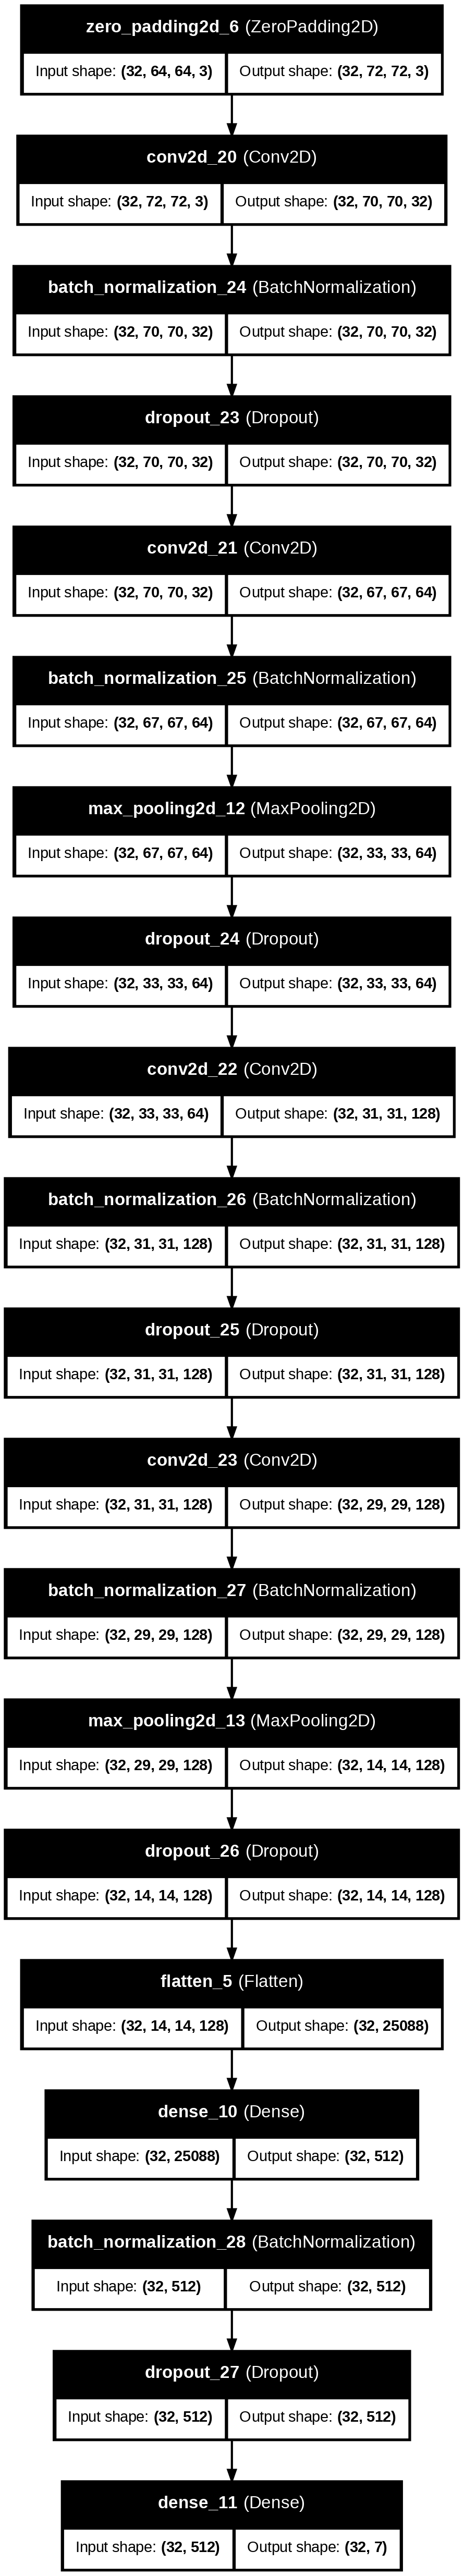


MATRICES DE CONFUSIÓN

Matriz de Confusión - Modelo 1: Modelo profundo (4 capas)


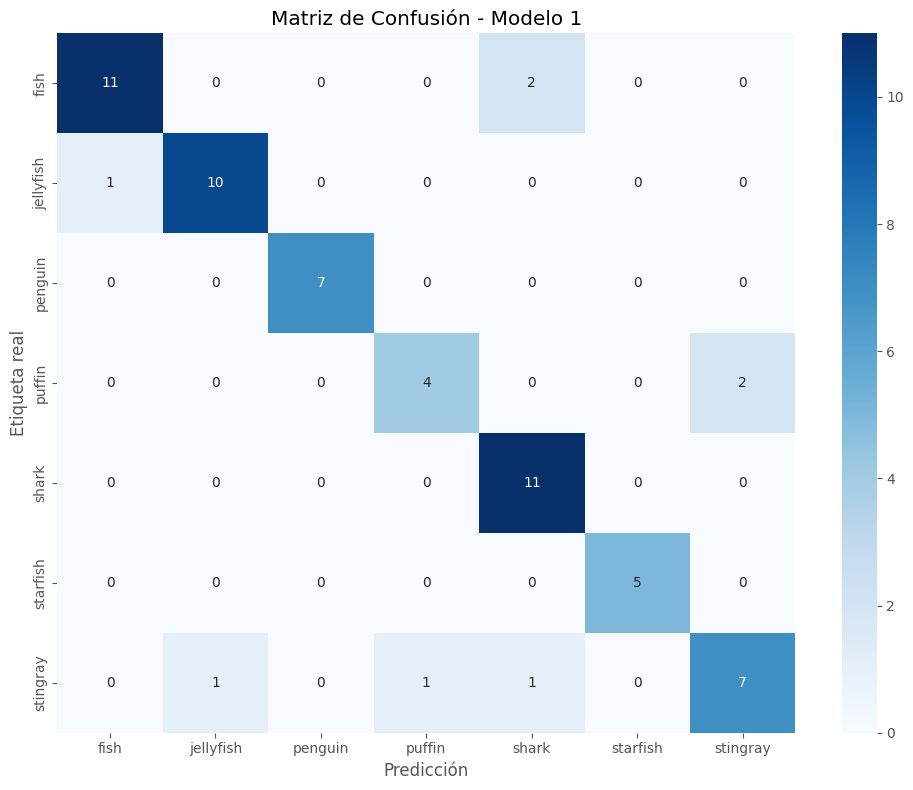

Precisión por clase:
  fish: 0.9167
  jellyfish: 0.9091
  penguin: 1.0000
  puffin: 0.8000
  shark: 0.7857
  starfish: 1.0000
  stingray: 0.7778

Recall por clase:
  fish: 0.8462
  jellyfish: 0.9091
  penguin: 1.0000
  puffin: 0.6667
  shark: 1.0000
  starfish: 1.0000
  stingray: 0.7000

Matriz de Confusión - Modelo 2: Modelo con kernels grandes (3 capas)


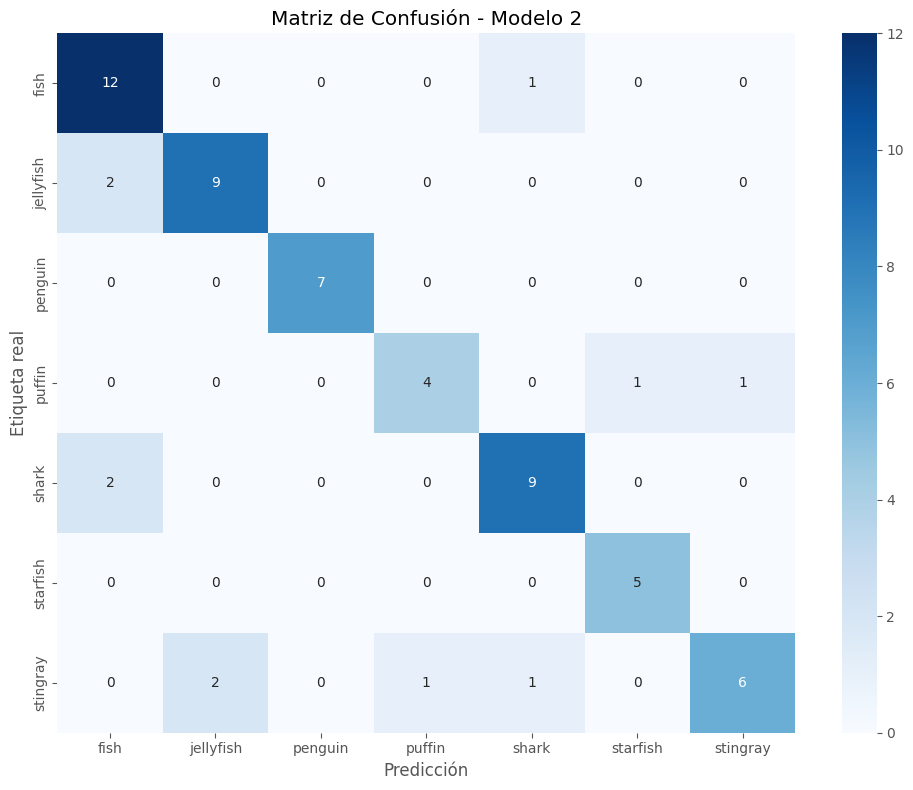

Precisión por clase:
  fish: 0.7500
  jellyfish: 0.8182
  penguin: 1.0000
  puffin: 0.8000
  shark: 0.8182
  starfish: 0.8333
  stingray: 0.8571

Recall por clase:
  fish: 0.9231
  jellyfish: 0.8182
  penguin: 1.0000
  puffin: 0.6667
  shark: 0.8182
  starfish: 1.0000
  stingray: 0.6000

Matriz de Confusión - Modelo 3: Modelo amplio (5 capas)


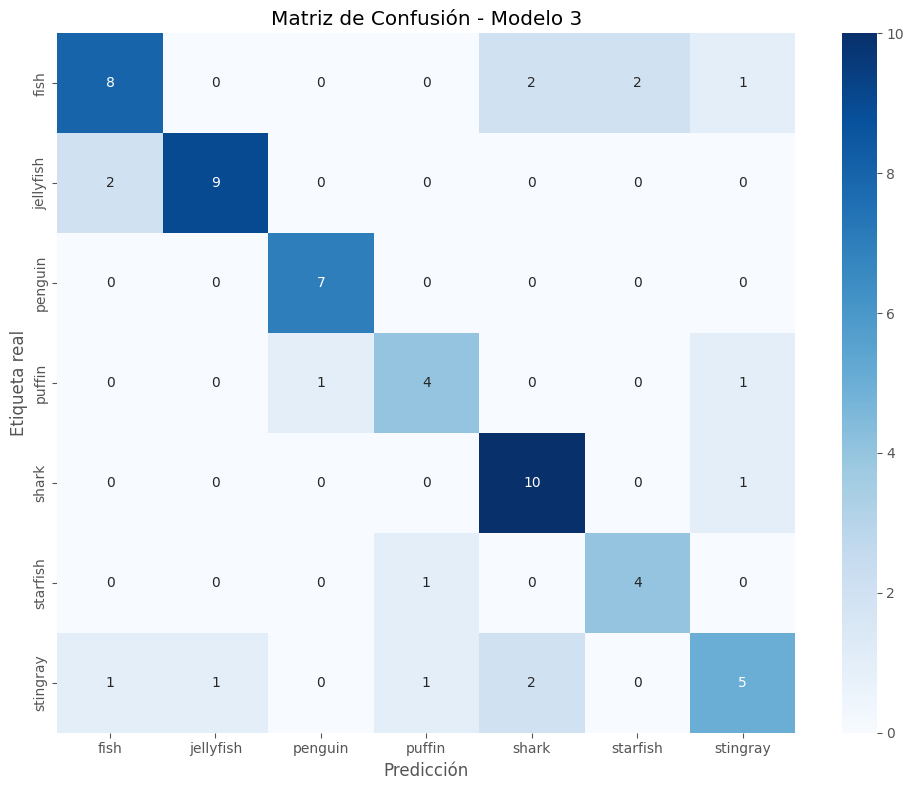

Precisión por clase:
  fish: 0.7273
  jellyfish: 0.9000
  penguin: 0.8750
  puffin: 0.6667
  shark: 0.7143
  starfish: 0.6667
  stingray: 0.6250

Recall por clase:
  fish: 0.6154
  jellyfish: 0.8182
  penguin: 1.0000
  puffin: 0.6667
  shark: 0.9091
  starfish: 0.8000
  stingray: 0.5000


In [31]:
# Comparar resultados de los modelos
print("\n" + "="*80)
print("COMPARACIÓN DE MODELOS")
print("="*80)
print(f"{'Modelo':^15} | {'# Capas':^10} | {'LR Factor':^10} | {'LR Patience':^12} | {'Val Acc':^10} | {'Test Acc':^10}")
print("-"*80)

for i, result in enumerate(model_results):
    print(f"{i+1:^15} | {result['num_layers']:^10} | {result['lr_factor']:^10.2f} | {result['lr_patience']:^12} | {result['best_val_accuracy']:^10.4f} | {result['test_accuracy']:^10.4f}")

# Seleccionar el mejor modelo basado en precisión de prueba
best_model_idx = np.argmax([r['test_accuracy'] for r in model_results])
best_result = model_results[best_model_idx]

print("\n" + "="*80)
print(f"MEJOR MODELO: #{best_model_idx+1} - {best_result['config']}")
print("="*80)
print(f"- Número de capas convolucionales: {best_result['num_layers']}")
print(f"- Factor de reducción LR: {best_result['lr_factor']}")
print(f"- Paciencia para reducción LR: {best_result['lr_patience']}")
print(f"- Mejor época: {best_result['best_epoch']}")
print(f"- Precisión de validación: {best_result['best_val_accuracy']:.4f}")
print(f"- Precisión de prueba: {best_result['test_accuracy']:.4f}")

# Mostrar la arquitectura del mejor modelo
print("\nArquitectura del mejor modelo:")
display(Image(filename=best_result['architecture_vertical']))

# Calcular y mostrar matrices de confusión para todos los modelos
print("\n" + "="*80)
print("MATRICES DE CONFUSIÓN")
print("="*80)

import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Definir nombres de clases para las etiquetas
class_names = ["fish", "jellyfish", "penguin", "puffin", "shark", "starfish", "stingray"]

# Calcular y visualizar las matrices de confusión para cada modelo
for i, result in enumerate(model_results):
    print(f"\nMatriz de Confusión - Modelo {i+1}: {result['config']}")
    model = result['model']

    # Recopilar etiquetas reales y predicciones
    y_true = []
    y_pred = []

    # Desactivar la barra de progreso para mantener la salida limpia
    for batch in ds_eval:
        images, labels = batch
        predictions = model.predict(images, verbose=0)
        y_true.extend(np.argmax(labels, axis=1))
        y_pred.extend(np.argmax(predictions, axis=1))

    # Calcular matriz de confusión
    cm = confusion_matrix(y_true, y_pred)

    # Visualizar la matriz de confusión
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicción')
    plt.ylabel('Etiqueta real')
    plt.title(f'Matriz de Confusión - Modelo {i+1}')
    plt.tight_layout()
    plt.show()

    # Calcular métricas adicionales por clase
    precision_per_class = np.diag(cm) / np.sum(cm, axis=0)
    recall_per_class = np.diag(cm) / np.sum(cm, axis=1)

    # Mostrar métricas por clase
    print("Precisión por clase:")
    for j, class_name in enumerate(class_names):
        print(f"  {class_name}: {precision_per_class[j]:.4f}")

    print("\nRecall por clase:")
    for j, class_name in enumerate(class_names):
        print(f"  {class_name}: {recall_per_class[j]:.4f}")

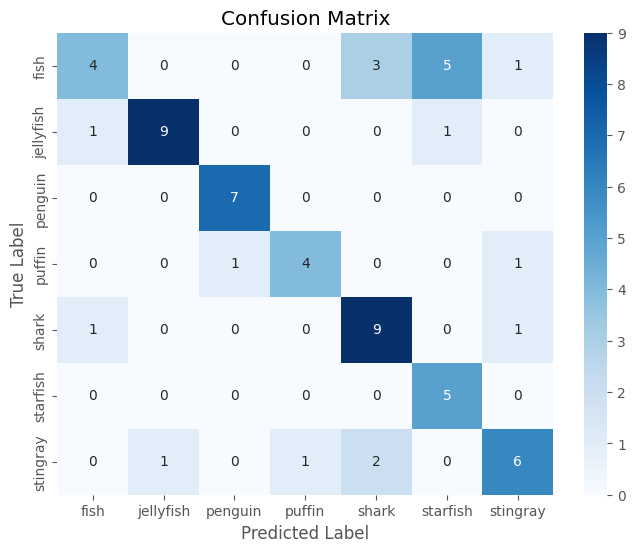

In [24]:
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Get all images and labels in a single batch
y_true = np.concatenate([y.numpy() for _, y in ds_eval])
y_pred = np.concatenate([model.predict(x, verbose=0) for x, _ in ds_eval])

# Convert from one-hot encoding to class indices
y_true = np.argmax(y_true, axis=1)
y_pred = np.argmax(y_pred, axis=1)

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

label_names = [class_mapping[i].decode() for i in range(7)]
# Display the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_names, yticklabels=label_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Código anterior

In [25]:
import os
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm
import shutil

# Directorios de datos originales
base_dir = "data"
train_dir = os.path.join(base_dir, "train")
valid_dir = os.path.join(base_dir, "valid")

# Directorios para datos procesados
processed_base = "data/processed"
processed_train_dir = os.path.join(processed_base, "train")
processed_valid_dir = os.path.join(processed_base, "validation")

os.makedirs(processed_train_dir, exist_ok=True)
os.makedirs(processed_valid_dir, exist_ok=True)

# Mapeo de clases a identificadores
class_mapping = {
  "fish": 1,
  "jellyfish": 2,
  "penguin": 3,
  "shark": 4,
  "puffin": 5,
  "stingray": 6,
  "starfish": 7
}

def process_folder(input_folder, output_folder, ann_df):
  """
  Procesa las imágenes en 'input_folder' y guarda en 'output_folder':
    - Copia la imagen original.
    - Si la imagen contiene más de una clase, genera una imagen sintética donde se reemplazan
      los píxeles de la clase predominante por el color medio del resto de la imagen.
    - Se registra la información en new_dataset.csv:
        * Para la imagen original se utiliza la primera clase (más frecuente).
        * Para la imagen sintética se utiliza la segunda clase (si existe).
  """
  info = []  # Lista para almacenar la información que se registrará en el CSV

  # Se obtienen los archivos de imagen (.jpg, .jpeg, .png)
  image_files = [f for f in os.listdir(input_folder) if f.lower().endswith((".jpg", ".jpeg", ".png"))]

  for name in tqdm(image_files, desc=f"Procesando {os.path.basename(input_folder)}"):
    path = os.path.join(input_folder, name)
    image = Image.open(path).convert("RGB")
    w, h = image.size
    mask = np.zeros((h, w), dtype=np.uint8)

    # Asignar en la máscara el identificador de cada clase según las anotaciones
    for _, row in ann_df[ann_df["filename"] == name].iterrows():
      cid = class_mapping[row["class"]]
      mask[int(row["ymin"]):int(row["ymax"]), int(row["xmin"]):int(row["xmax"])] = cid

    # Se obtienen las clases presentes y se elimina el fondo (0)
    uniques, counts = np.unique(mask, return_counts=True)
    counts_dict = dict(zip(uniques, counts))
    counts_dict.pop(0, None)  # Se elimina el fondo

    # Se ordenan las clases por cantidad de píxeles (de mayor a menor)
    sorted_classes = sorted(counts_dict.items(), key=lambda x: x[1], reverse=True)

    # Verificar que sorted_classes no esté vacío antes de acceder a su primer elemento
    if not sorted_classes:
      print(f"No se encontraron anotaciones para la imagen: {name}")
      continue  # Salta al siguiente elemento

    prim_id, prim_area = sorted_classes[0]
    prim_label = next(label for label, idx in class_mapping.items() if idx == prim_id)

    # Registro para la imagen original
    info.append({"filename": name, "predominant_class": prim_label, "area": prim_area})
    shutil.copy(path, os.path.join(output_folder, name))

    # Solo se genera la imagen sintética si hay más de una clase anotada
    if len(sorted_classes) > 1:
      sec_id, sec_area = sorted_classes[1]
      sec_label = next(label for label, idx in class_mapping.items() if idx == sec_id)

      arr = np.array(image)
      mask_prim = (mask == prim_id)
      mean_color = arr[~mask_prim].mean(axis=0).astype(np.uint8)
      syn_arr = arr.copy()
      syn_arr[mask_prim] = mean_color

      base, _ = os.path.splitext(name)
      syn_name = f"{base}_synthetic.jpg"
      Image.fromarray(syn_arr).save(os.path.join(output_folder, syn_name))

      info.append({"filename": syn_name, "predominant_class": sec_label, "area": sec_area})

  pd.DataFrame(info).to_csv(os.path.join(output_folder, "new_dataset.csv"), index=False)
  print(f"Procesamiento completado en {os.path.basename(input_folder)}. CSV guardado.")

# Lectura de anotaciones para conjuntos de entrenamiento y validación
train_ann = pd.read_csv(os.path.join(train_dir, "annotations.csv"))
valid_ann = pd.read_csv(os.path.join(valid_dir, "annotations.csv"))

process_folder(train_dir, processed_train_dir, train_ann)
process_folder(valid_dir, processed_valid_dir, valid_ann)

print("Todos los conjuntos han sido procesados correctamente.")

Procesando train: 100%|██████████| 1/1 [00:00<00:00, 59.27it/s]


No se encontraron anotaciones para la imagen: IMG_3133_jpeg_jpg.rf.f439b9d382fd153b96f0a88cdf169172.jpg
Procesamiento completado en train. CSV guardado.


Procesando valid: 0it [00:00, ?it/s]

Procesamiento completado en valid. CSV guardado.
Todos los conjuntos han sido procesados correctamente.


In [26]:
import tensorflow as tf
import pandas as pd
import os

# Ruta del archivo CSV
csv_path = r'data/processed/train/new_dataset.csv'
if not os.path.exists(csv_path):
    raise FileNotFoundError(f"No se encontró el archivo CSV en: {csv_path}")

# Cargar el CSV usando pandas
df = pd.read_csv(csv_path)
rutas_archivos = df['filename'].tolist()
etiquetas = df['predominant_class'].tolist()

# Obtener el directorio donde se encuentra el CSV y construir la ruta completa de cada imagen
directorio_csv = os.path.dirname(os.path.abspath(csv_path))
print("Directorio CSV:", directorio_csv)
rutas_imagenes = [os.path.join(directorio_csv, nombre) for nombre in rutas_archivos]

# Función auxiliar que se ejecuta en modo eager a través de tf.py_function
def _cargar_imagen(ruta, etiqueta):
    # Convertir el tensor a un valor numpy y luego decodificarlo a str
    ruta_str = ruta.numpy().decode('utf-8')
    # print("Cargando la imagen desde:", ruta_str)

    # Leer y decodificar la imagen
    imagen_bytes = tf.io.read_file(ruta_str)
    imagen_decoded = tf.image.decode_image(imagen_bytes, channels=3, expand_animations=False)
    imagen_resized = tf.image.resize(imagen_decoded, [256, 256])

    return imagen_resized, etiqueta

# Función de mapeo que utiliza tf.py_function para ejecutar _cargar_imagen en modo eager
def cargar_imagen(ruta, etiqueta):
    imagen, etiqueta_out = tf.py_function(
        func=_cargar_imagen,
        inp=[ruta, etiqueta],
        Tout=[tf.float32, etiqueta.dtype]
    )
    # Definir la forma fija de la imagen resultante para el grafo
    imagen.set_shape([256, 256, 3])
    return imagen, etiqueta_out

# Crear el dataset a partir de la lista de rutas y etiquetas
dataset = tf.data.Dataset.from_tensor_slices((rutas_imagenes, etiquetas))
dataset = dataset.map(cargar_imagen, num_parallel_calls=tf.data.AUTOTUNE)
dataset = dataset.shuffle(buffer_size=1000)
dataset = dataset.batch(1)
dataset = dataset.prefetch(tf.data.AUTOTUNE)

# Ejemplo de iterar sobre el dataset
for imagenes, labels in dataset.take(1):
    print("Batch de imágenes:", imagenes.shape)
    print("Batch de etiquetas:", labels)


EmptyDataError: No columns to parse from file

In [ ]:
ds_iter = dataset.take(1).as_numpy_iterator()
for el in ds_iter:
    print("Imagen:", el[0].shape, "Etiqueta:", el[1])
    break  # Solo para mostrar un ejemplo

In [ ]:
!dir